## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](example.png)

### Load and preprocess data

 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [4]:
### Useful routines for preparing data
from numpy import array, zeros
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize
import os
import cv2
import numpy as np
import pandas as pd

def load_imgs_and_keypoints(dirname='data'):
    # Write your code for loading images and points here
    imgs=[]
    heights=[]
    widths=[]
    for img in os.listdir(dirname+"/images"):
        img=cv2.imread(join(dirname,"images",img))
        heights.append(img.shape[0])
        widths.append(img.shape[1])
        img=cv2.resize(img,dsize=(100,100))  #in BGR
        RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(RGB_img)
    ret_imgs=np.stack(imgs)
    kp=pd.read_csv(join('data','gt.csv'))
    kp=kp.iloc[:,1:]
    for ix in range(kp.shape[1]):
        if ix%2==0:
            kp.iloc[:,ix]=kp.iloc[:,ix]/widths
        else:
            kp.iloc[:,ix]=kp.iloc[:,ix]/heights
    kp=kp-0.5
    ret_kps=kp.values
    return ret_imgs,ret_kps

imgs, points = load_imgs_and_keypoints()

array([-0.30534351, -0.30534351, -0.01526718, -0.27099237,  0.14503817,
       -0.2519084 ,  0.27480916, -0.30152672, -0.24045802, -0.20610687,
       -0.17557252, -0.21374046, -0.08015267, -0.1870229 ,  0.11068702,
       -0.16793893,  0.15267176, -0.19847328,  0.23664122, -0.17938931,
        0.09541985,  0.04961832, -0.14885496,  0.16412214,  0.03435115,
        0.1870229 ,  0.14122137,  0.18320611])

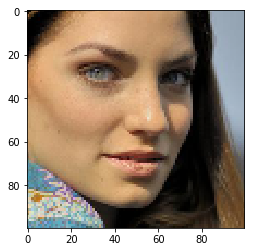

In [5]:
# Example of output
import matplotlib.pyplot as plt
%matplotlib inline

#from skimage.io import imshow
plt.imshow(imgs[0])
points[0]

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

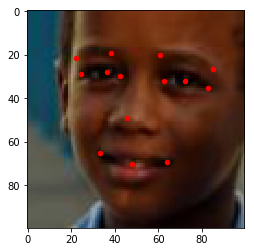

In [6]:
import matplotlib.pyplot as plt
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle

def visualize_points(img, points):
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image
    fig, ax = plt.subplots()
    im = ax.imshow(img)
    for i in range(len(points)//2):
        plt.plot((points[2*i]+0.5)*100, (points[2*i+1]+0.5)*100, 'o', color='red',markersize=4.5)
    
    plt.show()
    
visualize_points(imgs[1], points[1])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [7]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

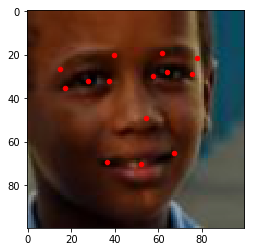

In [8]:
def flip_img(img, img_points):
    # Write your code for flipping here
    img=cv2.flip(img,1)
    new_points=np.copy(img_points)
    for ix in range(len(new_points)):
        if ix%2==0:
            new_points[ix]*=-1
    return img,new_points

f_img, f_points = flip_img(imgs[1], points[1])
visualize_points(f_img, f_points)

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [9]:
new_imgs,new_points=[],[]
for img,img_points in zip(imgs_train,points_train):
    f_img, f_points = flip_img(img, img_points)
    new_imgs.append(img)
    new_imgs.append(f_img)
    new_points.append(img_points)
    new_points.append(f_points)
    
aug_imgs_train=np.stack(new_imgs)
aug_points_train=np.stack(new_points)
aug_imgs_train.shape,aug_points_train.shape

((10800, 100, 100, 3), (10800, 28))

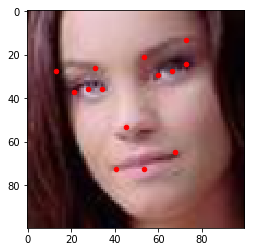

In [10]:
visualize_points(aug_imgs_train[0], aug_points_train[0])

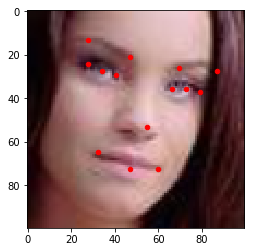

In [11]:
visualize_points(aug_imgs_train[1], aug_points_train[1])

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [12]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D,LeakyReLU,Dropout,Flatten,BatchNormalization
input_img=Input(shape=aug_imgs_train[1].shape)

x=Conv2D(32,(4,4),padding='same')(input_img)
x=BatchNormalization()(x)
x=LeakyReLU(alpha=0.1)(x)

x=MaxPooling2D((2,2),padding='same')(x)

x=Conv2D(64,(4,4),padding='same')(x)
x=BatchNormalization()(x)
x=LeakyReLU(alpha=0.1)(x)

x=MaxPooling2D((2,2),padding='same')(x)

x=Conv2D(128,(4,4),padding='same')(x)
x=BatchNormalization()(x)
x=LeakyReLU(alpha=0.1)(x)

x=MaxPooling2D((2,2),padding='same')(x)

x=Flatten()(x)

x=Dense(256,name='denseA')(x)
x=BatchNormalization()(x)
x=LeakyReLU(alpha=0.1)(x)
x=Dropout(0.3)(x)

x=Dense(512,name='denseB')(x)
x=BatchNormalization()(x)
x=LeakyReLU(alpha=0.1)(x)
x=Dropout(0.3)(x)

regressed=Dense(28,name='output')(x)

regressor=Model(input_img, regressed)

In [13]:
regressor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      1568      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 32)      128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 100, 100, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        32832     
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 50, 64)        256       
__________

Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [14]:
# ModelCheckpoint can be used for saving model during training.
# Saved models are useful for finetuning your model 
# See keras documentation for more info
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam
checkpoint=ModelCheckpoint('current_best_model.h5',save_best_only=True)
regressor.compile(optimizer='Adam', loss='mse')
#regressor.fit(aug_imgs_train,aug_points_train,epochs=10,batch_size=32,shuffle=True,validation_data=(imgs_val, points_val))
#train on gpu, load weights
# Choose optimizer, compile model and run training

In [16]:
regressor.load_weights("keypoints_regressor_trained_weights_1.h5")

In [30]:
regressor.evaluate(imgs_val,points_val)

600/600 [==============================] - 36s 60ms/step


0.004789057476446032

### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

In [17]:
# Example of output
predicted_keypoints=regressor.predict(imgs_val)
print(predicted_keypoints[0:5,:]) #check that outputs are different

[[-0.29028687 -0.2870295  -0.10106043 -0.3045324   0.09426564 -0.29724592
   0.2985186  -0.27368763 -0.24647076 -0.20495662 -0.17320545 -0.21049032
  -0.11526172 -0.20523386  0.10974402 -0.19697475  0.18694858 -0.19816552
   0.25725377 -0.19100878 -0.02214629  0.01558287 -0.15137339  0.17582765
  -0.01339946  0.18484077  0.11618083  0.18715847]
 [-0.41251707 -0.23323298 -0.16438478 -0.27852032  0.08662241 -0.3016038
   0.3401744  -0.31202924 -0.33998317 -0.15936714 -0.24385232 -0.17652844
  -0.16548726 -0.17990096  0.11518902 -0.19676316  0.21163884 -0.21451822
   0.299219   -0.22137764  0.01226773  0.03986118 -0.14534034  0.19505744
   0.04048006  0.19690973  0.18429638  0.16393997]
 [-0.32395005 -0.2598667  -0.12450281 -0.2658626   0.05218751 -0.2806169
   0.27533293 -0.29541832 -0.26010537 -0.17042226 -0.17756225 -0.18313274
  -0.115734   -0.18539168  0.09293517 -0.17997478  0.16386876 -0.20158061
   0.2441972  -0.2032887   0.01705608  0.04154723 -0.05474759  0.21030235
   0.0599336

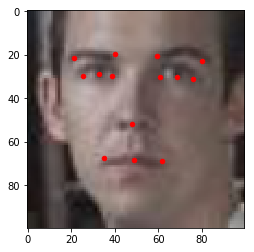

In [28]:
visualize_points(imgs_val[0],predicted_keypoints[0]) #visualize one image

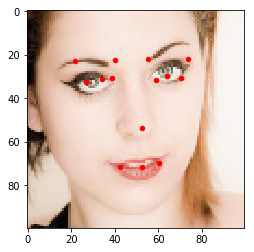

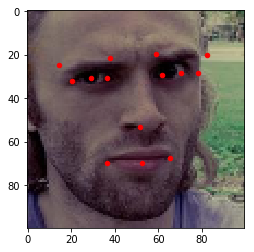

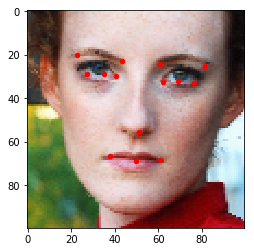

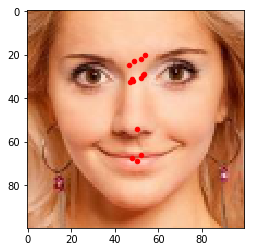

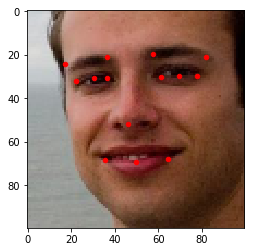

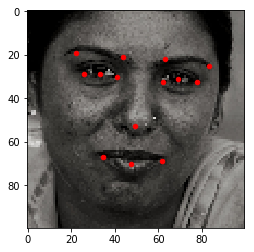

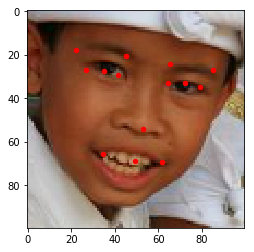

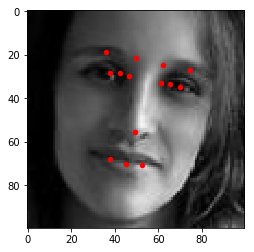

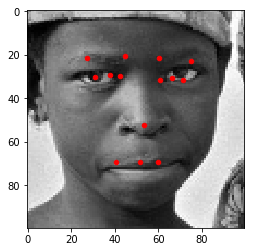

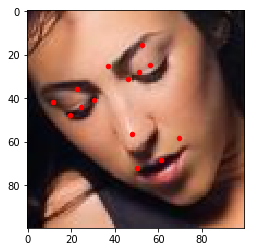

In [25]:
#visualize several others from validaation set
for i in range(10):
    ix=np.random.choice(range(imgs_val.shape[0]))
    visualize_points(imgs_val[ix],predicted_keypoints[ix])

In [20]:
#test on unseen images from the internet
def test_on_unseen_images(full_image_path):
    img=cv2.imread(full_image_path)
    img=cv2.resize(img,dsize=(100,100))  #in BGR
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=np.reshape(RGB_img,newshape=(1,RGB_img.shape[0],RGB_img.shape[1],RGB_img.shape[2]))
    print(img.shape)
    visualize_points(RGB_img,regressor.predict(img)[0])

In [ ]:
!wget http://dreamatico.com/data_images/face/face-1.jpg

(1, 100, 100, 3)


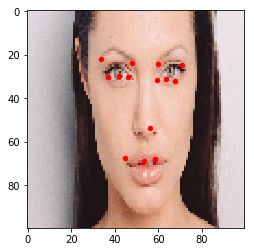

In [21]:
test_on_unseen_images('face-1.jpg')

In [ ]:
!wget https://pe-images.s3.amazonaws.com/photo-effects/photo-fill/main-cropped.jpg

(1, 100, 100, 3)


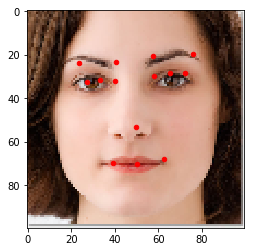

In [22]:
test_on_unseen_images('main-cropped.jpg')